# 1.Setup

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
# from torchvision.transforms import ToTensor, ToPILImage, Lambda, Compose
# from torchvision.utils import make_grid

from torch.utils.data import Dataset, DataLoader


import torch.nn.functional as F

# 定义损失函数和优化器
import torch.optim as optim

import matplotlib.pyplot as plt 
import numpy as np 

print(torch.cuda.is_available())
print(torch.__version__)

False
1.8.0


# 2.数据、模型全局变量

In [30]:
# 超参数
learning_rate = 1e-3
batch_size = 4
epochs = 2

# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# 3.数据下载、加载

## 3.1 数据下载

In [18]:
# 数据处理转化器
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 训练数据
train_set = torchvision.datasets.CIFAR10(
    root = "data", 
    train = True,
    download = False, 
    transform = transform
)

# 测试数据
test_set = torchvision.datasets.CIFAR10(
    root = "data", 
    train = False,
    download = False, 
    transform = transform
)

## 3.2 数据加载--创建 data loader

In [19]:
# 训练数据
train_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size = batch_size, 
    shuffle = True, 
    num_workers = 2
)

# 测试数据
test_loader = torch.utils.data.DataLoader(
    test_set, 
    batch_size = batch_size, 
    shuffle = False, 
    num_workers = 2
)

# 类别
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [20]:
for X_train, y_train in train_loader:
    print("Shape of X_train [N, C, H, W]: ", X_train.shape)
    print("Shape of y_train: ", y_train.shape, y_train.dtype)
    break

Shape of X_train [N, C, H, W]:  torch.Size([4, 3, 32, 32])
Shape of y_train:  torch.Size([4]) torch.int64


## 3.3 数据查看

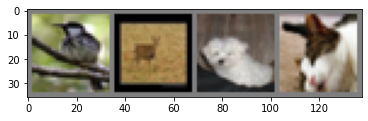

 bird         deer          dog          cat


In [25]:
# 查看训练数据
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print("        ".join("%5s" % classes[labels[j]] for j in range(batch_size)))

# 4.模型构建和训练

## 4.1 定义卷积神经网络

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        # x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## 4.2 定义损失函数和优化器

In [29]:
# 损失函数
loss_fn = nn.CrossEntropyLoss()

# 优化器
optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = 0.9)

## 4.3 模型训练

In [32]:
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameters gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print("[%d, %d] loss: %.3f" %  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print("Finished Training.")

[1, 2000] loss: 2.224
[1, 4000] loss: 1.891
[1, 6000] loss: 1.703
[1, 8000] loss: 1.567
[1, 10000] loss: 1.519
[1, 12000] loss: 1.457
[2, 2000] loss: 1.387
[2, 4000] loss: 1.367
[2, 6000] loss: 1.331
[2, 8000] loss: 1.317
[2, 10000] loss: 1.282
[2, 12000] loss: 1.270
Finished Training.


## 4.4 模型保存

In [33]:
torch.save(net.state_dict(), "./model/cifar_net.pth")
print("Saved PyTorch Model State to model/cifar_net.pth.")

Saved PyTorch Model State to model/cifar_net.pth.


# 5.模型重载、预测

## 5.1 模型测试

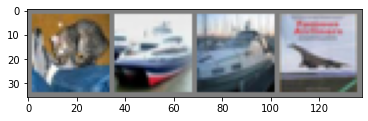

  cat         ship         ship        plane


In [40]:
# 查看训练数据
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print image
imshow(torchvision.utils.make_grid(images))

# print label
print("        ".join("%5s" % classes[labels[j]] for j in range(batch_size)))

In [41]:
# 模型载入
net = Net()
net.load_state_dict(torch.load("./model/cifar_net.pth"))

outputs = net(images)
_, predicted = torch.max(outputs, 1)
print("Predicted: ", " ".join("%5s" % classes[predicted[j]] for j in range(4)))

Predicted:   frog  ship  ship plane


## 5.2 模型测试

In [42]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of the network on the 10000 test images: %d %%" % (100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [46]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

Accuracy for class plane is: 38.6 %
Accuracy for class car   is: 72.7 %
Accuracy for class bird  is: 46.1 %
Accuracy for class cat   is: 28.1 %
Accuracy for class deer  is: 64.8 %
Accuracy for class dog   is: 38.1 %
Accuracy for class frog  is: 68.0 %
Accuracy for class horse is: 50.6 %
Accuracy for class ship  is: 84.6 %
Accuracy for class truck is: 54.5 %


In [47]:
# 在GPU上训练模型
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)

cpu
